# HCICS MVP Data Exploration
 
**Project:** Humanitarian Crisis Intelligence and Communication System (HCICS)
 
**Purpose:** Explore cleaned IDP displacement data and health facility distribution
to understand the humanitarian landscape in Sudan before conducting formal analysis.
 
**Author:** Abdulrahman Ali
 
**Date:** November 8, 2025
 
## Objectives
 
This exploration notebook aims to:
1. Understand the distribution of IDPs across Sudan
2. Examine health facility availability and types
3. Identify potential geographic mismatches between IDP populations and health services
4. Generate descriptive statistics and visualizations to inform the analysis phase
 
**Note:** This is exploratory analysis only - no inferential statistics or predictive modeling will be performed at this stage.

## Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Visualization style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

# Data paths
DATA_PATH = Path("../1_datasets/clean")

In [2]:
idps_state = pd.read_csv(DATA_PATH / "clean_idps_state.csv")
idps_locality = pd.read_csv(DATA_PATH / "clean_idps_locality.csv")
facilities = pd.read_csv(DATA_PATH / "clean_health_facilities.csv")
localities = pd.read_csv(DATA_PATH / "lookup_localities.csv")
states = pd.read_csv(DATA_PATH / "lookup_states.csv")

print("Data loaded successfully")
print(f"  - IDP State records: {len(idps_state):,}")
print(f"  - IDP Locality records: {len(idps_locality):,}")
print(f"  - Health facilities: {len(facilities):,}")
print(f"  - Localities: {len(localities):,}")
print(f"  - States: {len(states):,}")

Data loaded successfully
  - IDP State records: 18
  - IDP Locality records: 181
  - Health facilities: 1,126
  - Localities: 189
  - States: 19


## 1. IDP Population Distribution

Understanding where displaced populations are concentrated is critical for 
humanitarian response planning.

### 1.1 National Overview

In [3]:
total_idps = idps_state["total_idps"].sum()
total_households = idps_state["total_households"].sum()

print("NATIONAL IDP STATISTICS:")
print(f"Total IDPs: {total_idps:,}")
print(f"Total Households: {total_households:,}")
print(f"Average Household Size: {total_idps/total_households:.2f}")
print(f"Number of States with IDPs: {len(idps_state)}")

NATIONAL IDP STATISTICS:
Total IDPs: 6,552,118
Total Households: 1,308,617
Average Household Size: 5.01
Number of States with IDPs: 18


### 1.2 Top 10 States by IDP Concentration

In [4]:
top_states = idps_state.nlargest(10, "total_idps")[
    ["state_displacement", "total_idps", "displacement_concentration_pct"]
].copy()

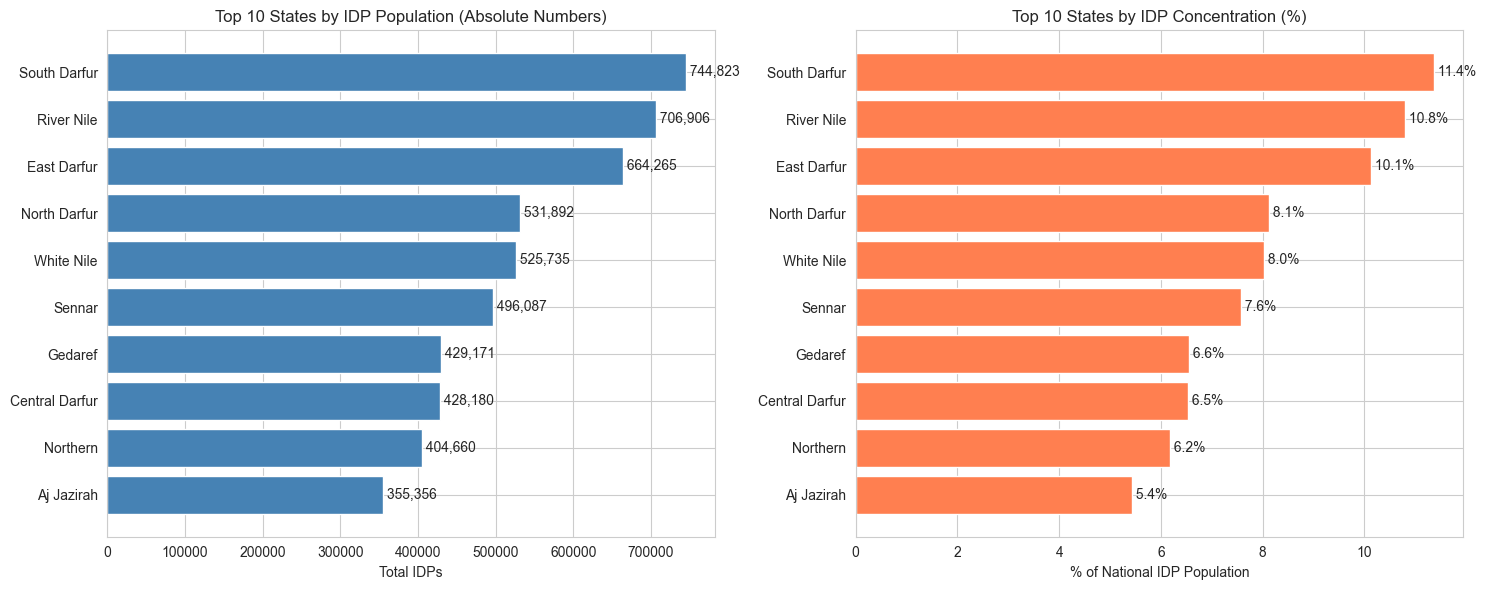

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Horizontal Bar chart of absolute numbers
ax1.barh(top_states["state_displacement"], top_states["total_idps"], color="steelblue")
ax1.set_xlabel("Total IDPs")
ax1.set_title("Top 10 States by IDP Population (Absolute Numbers)")
ax1.invert_yaxis()
for i, v in enumerate(top_states["total_idps"]):
    ax1.text(v, i, f" {v:,.0f}", va="center")
ax2.barh(
    top_states["state_displacement"],
    top_states["displacement_concentration_pct"],
    color="coral",
)
ax2.set_xlabel("% of National IDP Population")
ax2.set_title("Top 10 States by IDP Concentration (%)")
ax2.invert_yaxis()
for i, v in enumerate(top_states["displacement_concentration_pct"]):
    ax2.text(v, i, f" {v:.1f}%", va="center")

plt.tight_layout()
plt.show()

### 1.3 Locality-Level Distribution

# Examining IDP distribution at the locality level reveals more granular patterns.

In [6]:
# Top 15 localities by IDP population
top_localities = idps_locality.nlargest(15, "total_idps")[
    ["locality_displacement", "state_displacement", "total_idps"]
]

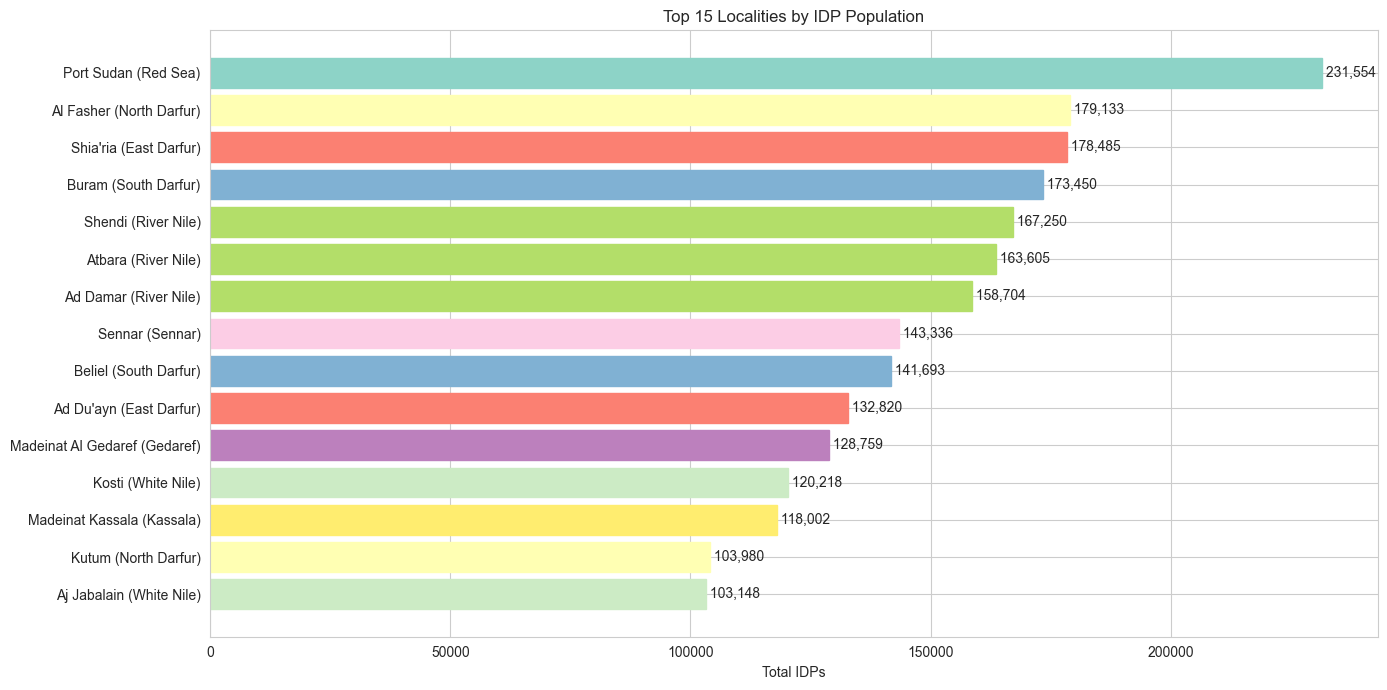

In [7]:
plt.figure(figsize=(14, 7))
bars = plt.barh(range(len(top_localities)), top_localities["total_idps"])

states_in_top = top_localities["state_displacement"].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(states_in_top)))
state_colors = dict(zip(states_in_top, colors))

for i, (idx, row) in enumerate(top_localities.iterrows()):
    bars[i].set_color(state_colors[row["state_displacement"]])

plt.yticks(
    range(len(top_localities)),
    [
        f"{row['locality_displacement']} ({row['state_displacement']})"
        for _, row in top_localities.iterrows()
    ],
)
plt.xlabel("Total IDPs")
plt.title("Top 15 Localities by IDP Population")
plt.gca().invert_yaxis()

for i, v in enumerate(top_localities["total_idps"]):
    plt.text(v, i, f" {v:,.0f}", va="center")

plt.tight_layout()
plt.show()

### 1.4 IDP Origins: Where Are People Fleeing From?

Understanding displacement origins helps identify conflict hotspots.

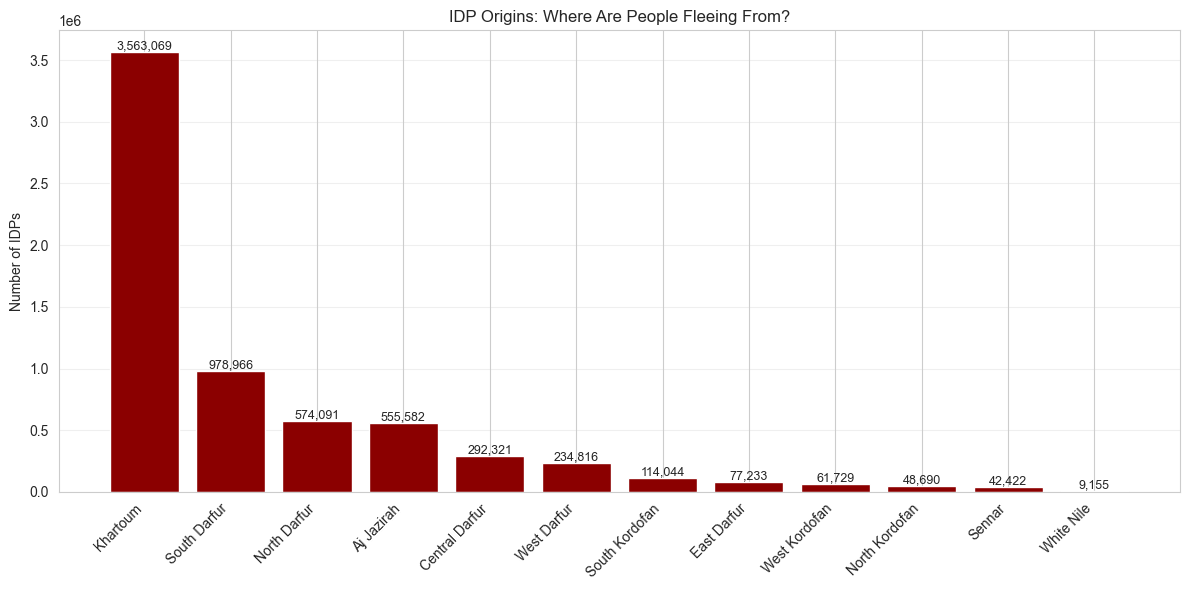


Primary displacement origin: Khartoum (3,563,069 IDPs)
This represents 54.4% of all IDPs


In [8]:
origin_cols = [col for col in idps_state.columns if col.startswith("origin_")]
origin_totals = idps_state[origin_cols].sum().sort_values(ascending=False)

origin_totals.index = (
    origin_totals.index.str.replace("origin_", "").str.replace("_", " ").str.title()
)

plt.figure(figsize=(12, 6))
plt.bar(range(len(origin_totals)), origin_totals.values, color="darkred")
plt.xticks(range(len(origin_totals)), origin_totals.index, rotation=45, ha="right")
plt.ylabel("Number of IDPs")
plt.title("IDP Origins: Where Are People Fleeing From?")
plt.grid(axis="y", alpha=0.3)

for i, v in enumerate(origin_totals.values):
    if v > 0:
        plt.text(i, v, f"{v:,.0f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

print(
    f"\nPrimary displacement origin: {origin_totals.index[0]} ({origin_totals.values[0]:,} IDPs)"
)
print(f"This represents {origin_totals.values[0]/total_idps*100:.1f}% of all IDPs")

## 2. Health Facility Distribution

Examining the availability and distribution of health services across Sudan.

### 2.1 Facility Types Overview

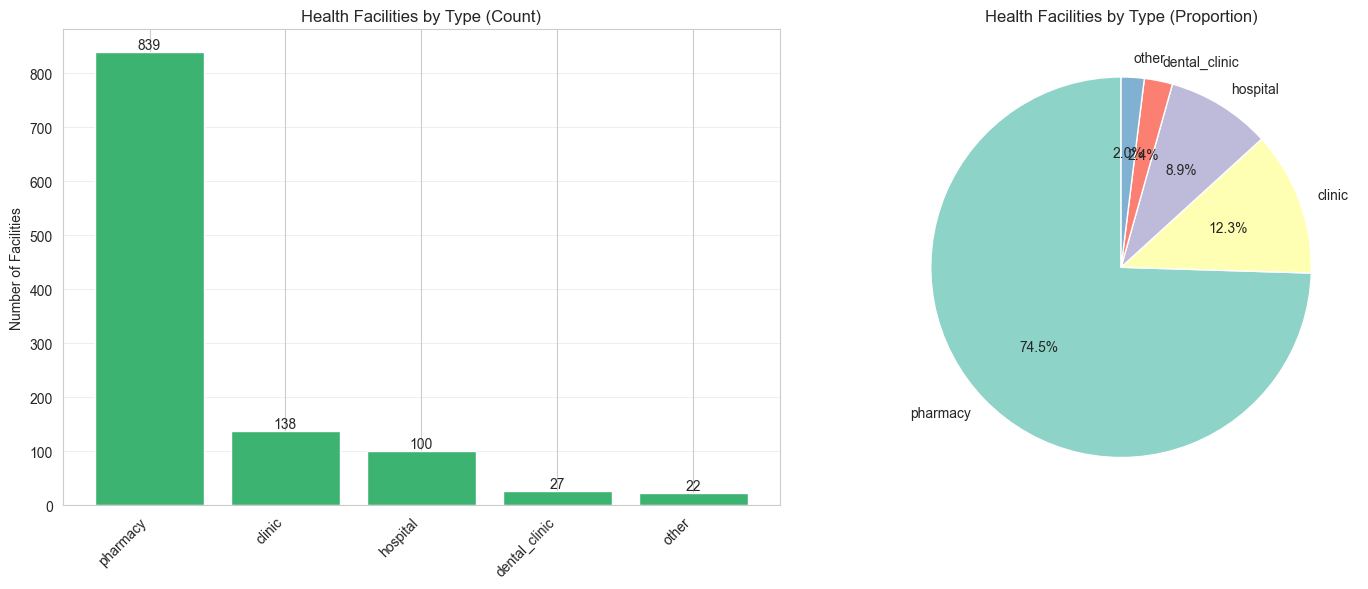


TOTAL FACILITIES: 1,126

Facility Type Breakdown:
  Pharmacy: 839 (74.5%)
  Clinic: 138 (12.3%)
  Hospital: 100 (8.9%)
  Dental_Clinic: 27 (2.4%)
  Other: 22 (2.0%)


In [9]:
# Facility Type
facility_counts = facilities["facility_type_standard"].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart
ax1.bar(range(len(facility_counts)), facility_counts.values, color="mediumseagreen")
ax1.set_xticks(range(len(facility_counts)))
ax1.set_xticklabels(facility_counts.index, rotation=45, ha="right")
ax1.set_ylabel("Number of Facilities")
ax1.set_title("Health Facilities by Type (Count)")
ax1.grid(axis="y", alpha=0.3)

for i, v in enumerate(facility_counts.values):
    ax1.text(i, v, f"{v}", ha="center", va="bottom")

# Pie chart
ax2.pie(
    facility_counts.values,
    labels=facility_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=plt.cm.Set3(range(len(facility_counts))),
)
ax2.set_title("Health Facilities by Type (Proportion)")

plt.tight_layout()
plt.show()

print(f"\nTOTAL FACILITIES: {len(facilities):,}")
print("\nFacility Type Breakdown:")
for ftype, count in facility_counts.items():
    print(f"  {ftype.title()}: {count} ({count/len(facilities)*100:.1f}%)")

### 2.2 Critical Facilities: Hospitals and Clinics

Hospitals and clinics are most critical for IDP populations. Let's examine their distribution.

In [10]:
critical_facilities = facilities[
    facilities["facility_type_standard"].isin(["hospital", "clinic"])
].copy()

print("CRITICAL HEALTH FACILITIES:")
print(
    f"Hospitals: {len(facilities[facilities['facility_type_standard']=='hospital']):,}"
)
print(f"Clinics: {len(facilities[facilities['facility_type_standard']=='clinic']):,}")
print(f"Total Critical Facilities: {len(critical_facilities):,}")
print(
    f"Percentage of all facilities: {len(critical_facilities)/len(facilities)*100:.1f}%"
)

CRITICAL HEALTH FACILITIES:
Hospitals: 100
Clinics: 138
Total Critical Facilities: 238
Percentage of all facilities: 21.1%


### 2.3 Data Quality: Facility Names and Locations

FACILITY DATA QUALITY:
Total Facilities: 1,126 (100.0%)
With Original Names: 1,092 (97.0%)
With English Translation: 1,092 (97.0%)
High Precision Location: 1,092 (97.0%)
Valid Coordinates: 1,126 (100.0%)


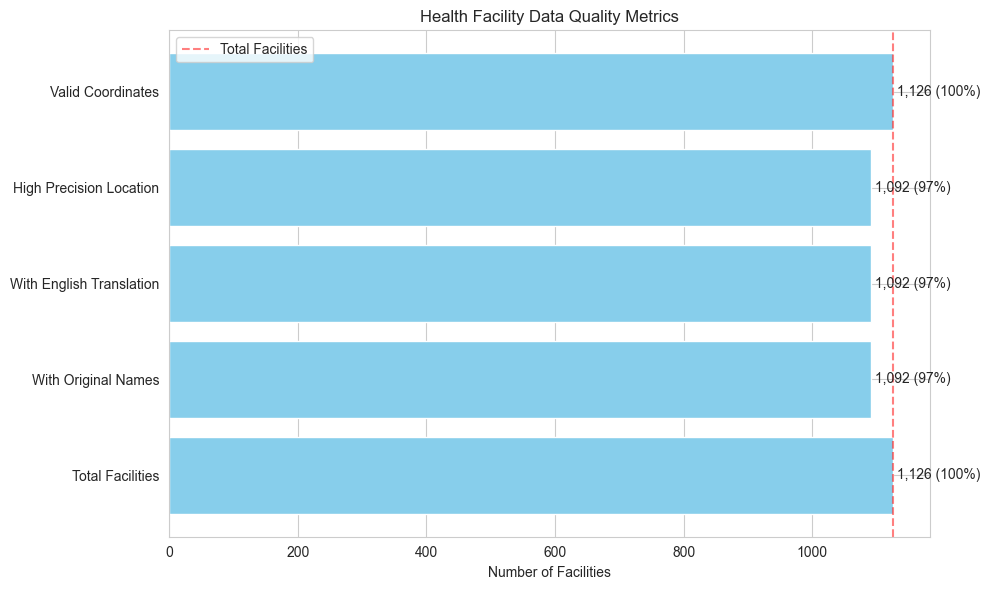

In [11]:
# Data Quality Assessment
quality_metrics = {
    "Total Facilities": len(facilities),
    "With Original Names": facilities["has_original_name"].sum(),
    "With English Translation": facilities["facility_name_english"].notna().sum(),
    "High Precision Location": (facilities["location_precision"] == "high").sum(),
    "Valid Coordinates": facilities["coordinates_valid"].sum(),
}

print("FACILITY DATA QUALITY:")
for metric, value in quality_metrics.items():
    pct = value / len(facilities) * 100
    print(f"{metric}: {value:,} ({pct:.1f}%)")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(
    list(quality_metrics.keys()), list(quality_metrics.values()), color="skyblue"
)
ax.set_xlabel("Number of Facilities")
ax.set_title("Health Facility Data Quality Metrics")
ax.axvline(
    len(facilities), color="red", linestyle="--", alpha=0.5, label="Total Facilities"
)

for i, v in enumerate(quality_metrics.values()):
    ax.text(v, i, f" {v:,} ({v/len(facilities)*100:.0f}%)", va="center")

ax.legend()
plt.tight_layout()
plt.show()

## 3. Geographic Mismatches: Preliminary Observations
 
This section explores potential mismatches between IDP concentrations and health facility availability.

### 3.1 State-Level IDP-to-Facility Ratio

**Note:** This is a crude metric - actual analysis will use proper spatial accessibility calculations.

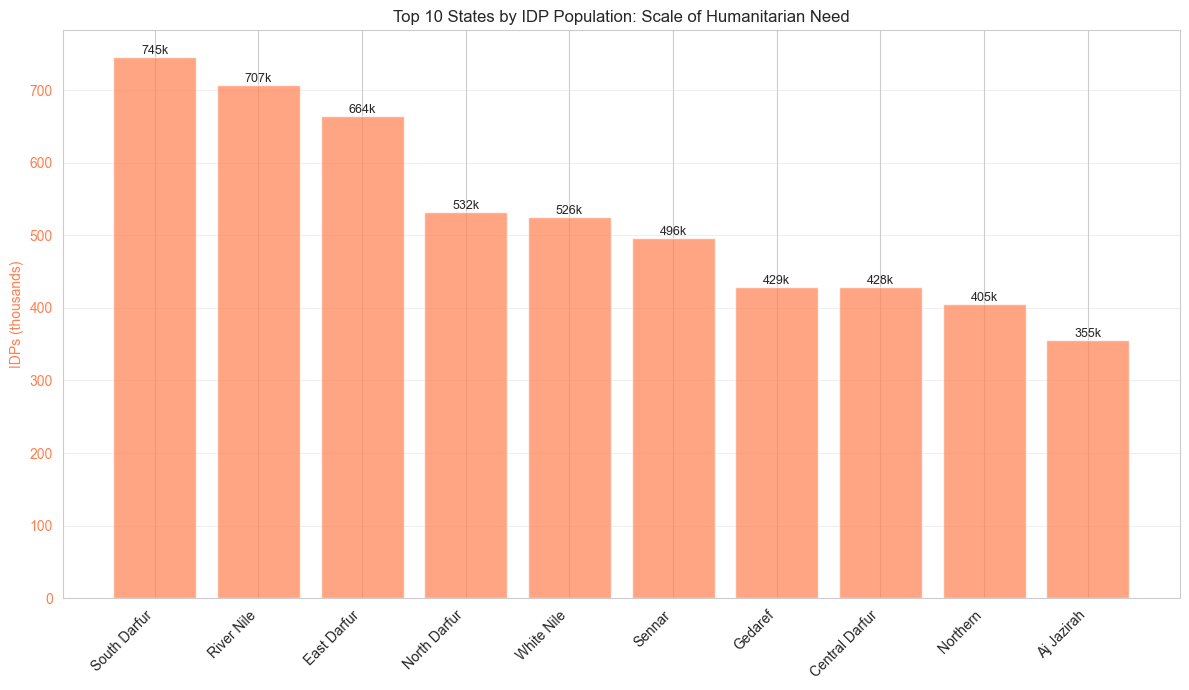


KEY OBSERVATION:
The next analysis phase will calculate spatial accessibility metrics to
identify areas where IDP populations lack adequate access to health facilities.


In [12]:
# Get top 10 IDP states
top_10_states = idps_state.nlargest(10, "total_idps")[
    ["state_displacement", "total_idps"]
].copy()

# Create a simple visualization showing the challenge
fig, ax = plt.subplots(figsize=(12, 7))

# Bar chart showing IDP populations (thousands)
x = np.arange(len(top_10_states))
bars = ax.bar(x, top_10_states["total_idps"] / 1000, color="coral", alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels(top_10_states["state_displacement"], rotation=45, ha="right")
ax.set_ylabel("IDPs (thousands)", color="coral")
ax.set_title("Top 10 States by IDP Population: Scale of Humanitarian Need")
ax.tick_params(axis="y", labelcolor="coral")
ax.grid(axis="y", alpha=0.3)

for i, v in enumerate(top_10_states["total_idps"]):
    ax.text(i, v / 1000, f"{v/1000:.0f}k", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

print("\nKEY OBSERVATION:")
print("The next analysis phase will calculate spatial accessibility metrics to")
print("identify areas where IDP populations lack adequate access to health facilities.")

## 4. Household Characteristics
Understanding IDP household composition provides context for service planning.

### 4.1 Average Household Size Distribution

HOUSEHOLD SIZE STATISTICS:
Mean: 5.03 persons/household
Median: 5.00 persons/household
Std Dev: 0.13
Range: 4.41 - 5.98


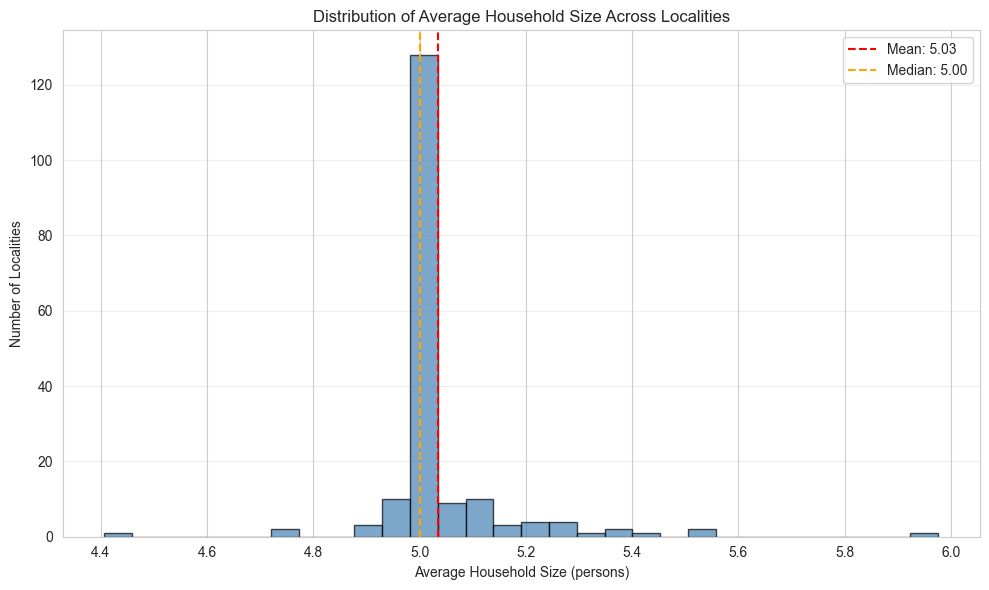

In [13]:
# Household size analysis
household_stats = idps_locality["avg_household_size"].describe()

print("HOUSEHOLD SIZE STATISTICS:")
print(f"Mean: {household_stats['mean']:.2f} persons/household")
print(f"Median: {household_stats['50%']:.2f} persons/household")
print(f"Std Dev: {household_stats['std']:.2f}")
print(f"Range: {household_stats['min']:.2f} - {household_stats['max']:.2f}")

# Histogram
plt.figure(figsize=(10, 6))
plt.hist(
    idps_locality["avg_household_size"].dropna(),
    bins=30,
    color="steelblue",
    edgecolor="black",
    alpha=0.7,
)
plt.axvline(
    household_stats["mean"],
    color="red",
    linestyle="--",
    label=f"Mean: {household_stats['mean']:.2f}",
)
plt.axvline(
    household_stats["50%"],
    color="orange",
    linestyle="--",
    label=f"Median: {household_stats['50%']:.2f}",
)
plt.xlabel("Average Household Size (persons)")
plt.ylabel("Number of Localities")
plt.title("Distribution of Average Household Size Across Localities")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### 4.2 Non-Sudanese IDP Population

NATIONALITY BREAKDOWN:
Sudanese Nationals: 6,432,927 (98.2%)
Non-Sudanese Nationals: 119,191 (1.8%)


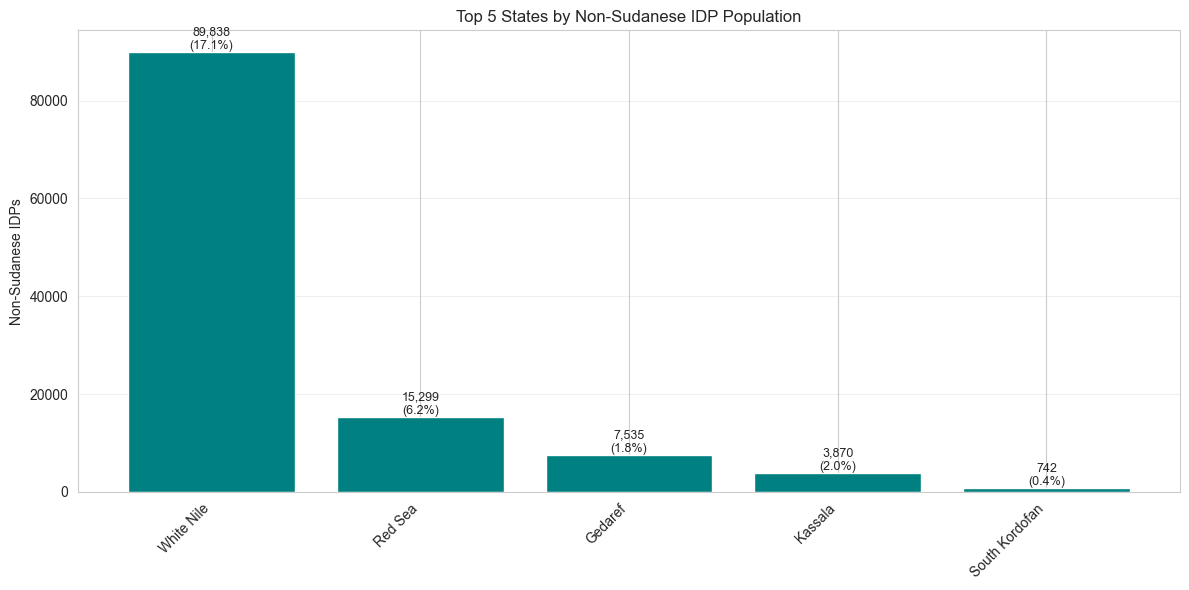

In [14]:
non_sudanese_total = idps_state["non_sudanese_nationals"].sum()
sudanese_total = idps_state["sudanese_nationals"].sum()

print("NATIONALITY BREAKDOWN:")
print(f"Sudanese Nationals: {sudanese_total:,} ({sudanese_total/total_idps*100:.1f}%)")
print(
    f"Non-Sudanese Nationals: {non_sudanese_total:,} ({non_sudanese_total/total_idps*100:.1f}%)"
)

top_non_sudanese = idps_state.nlargest(5, "non_sudanese_nationals")[
    ["state_displacement", "non_sudanese_nationals", "non_sudanese_percentage"]
]

if len(top_non_sudanese) > 0 and top_non_sudanese["non_sudanese_nationals"].sum() > 0:
    plt.figure(figsize=(12, 6))
    x = range(len(top_non_sudanese))
    bars = plt.bar(x, top_non_sudanese["non_sudanese_nationals"], color="teal")
    plt.xticks(x, top_non_sudanese["state_displacement"], rotation=45, ha="right")
    plt.ylabel("Non-Sudanese IDPs")
    plt.title("Top 5 States by Non-Sudanese IDP Population")
    plt.grid(axis="y", alpha=0.3)

    for i, (idx, row) in enumerate(top_non_sudanese.iterrows()):
        plt.text(
            i,
            row["non_sudanese_nationals"],
            f"{row['non_sudanese_nationals']:,.0f}\n({row['non_sudanese_percentage']:.1f}%)",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    plt.tight_layout()
    plt.show()

## 5. Hierarchical Data Structure Analysis

For the interactive dashboard, we need both state-level (overview) and locality-level (drill-down) data. This section validates the hierarchical structure.

### 5.1 State-Locality Relationships

STATE-LOCALITY HIERARCHICAL STRUCTURE:
Total States: 18
Total Localities: 181
Avg Localities per State: 10.1

Top 5 States by Number of Localities:
state_displacement  num_localities  total_idps
      South Darfur              19      744823
      North Darfur              17      531892
    South Kordofan              14      174483
     West Kordofan              14      138096
           Gedaref              12      429171


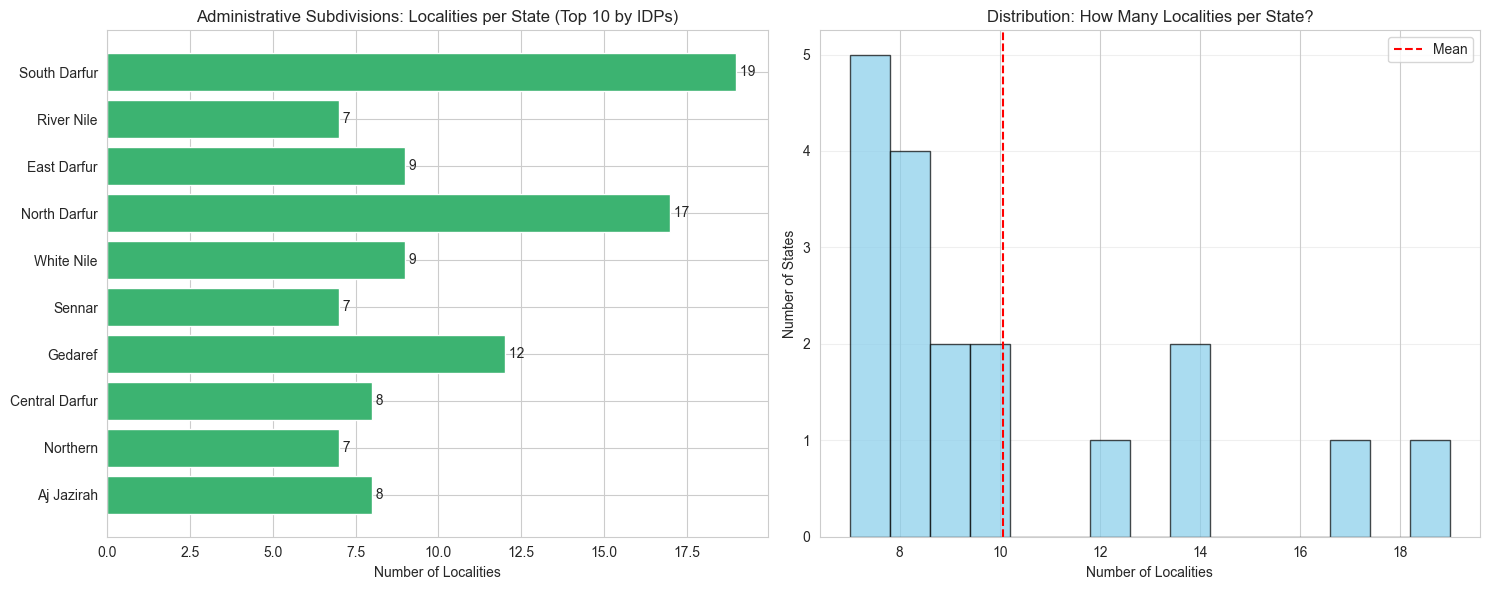

In [15]:
localities_per_state = (
    idps_locality.groupby("state_displacement")
    .size()
    .reset_index(name="num_localities")
)
localities_per_state = localities_per_state.merge(
    idps_state[["state_displacement", "total_idps"]],
    on="state_displacement",
    how="left",
).sort_values("total_idps", ascending=False)

print("STATE-LOCALITY HIERARCHICAL STRUCTURE:")
print(f"Total States: {len(localities_per_state)}")
print(f"Total Localities: {localities_per_state['num_localities'].sum()}")
print(f"Avg Localities per State: {localities_per_state['num_localities'].mean():.1f}")
print("\nTop 5 States by Number of Localities:")
print(
    localities_per_state.nlargest(5, "num_localities")[
        ["state_displacement", "num_localities", "total_idps"]
    ].to_string(index=False)
)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

top_10_states_loc = localities_per_state.nlargest(10, "total_idps")
ax1.barh(
    top_10_states_loc["state_displacement"],
    top_10_states_loc["num_localities"],
    color="mediumseagreen",
)
ax1.set_xlabel("Number of Localities")
ax1.set_title("Administrative Subdivisions: Localities per State (Top 10 by IDPs)")
ax1.invert_yaxis()

for i, v in enumerate(top_10_states_loc["num_localities"]):
    ax1.text(v, i, f" {v}", va="center")

# Distribution of localities per state
ax2.hist(
    localities_per_state["num_localities"],
    bins=15,
    color="skyblue",
    edgecolor="black",
    alpha=0.7,
)
ax2.set_xlabel("Number of Localities")
ax2.set_ylabel("Number of States")
ax2.set_title("Distribution: How Many Localities per State?")
ax2.axvline(
    localities_per_state["num_localities"].mean(),
    color="red",
    linestyle="--",
    label="Mean",
)
ax2.legend()
ax2.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

### 5.2 Data Aggregation Validation

Verify that locality-level data correctly aggregates to state-level totals.

In [17]:
locality_aggregated = (
    idps_locality.groupby("state_displacement")
    .agg({"total_idps": "sum", "total_households": "sum"})
    .reset_index()
)

validation = locality_aggregated.merge(
    idps_state[["state_displacement", "total_idps", "total_households"]],
    on="state_displacement",
    suffixes=("_locality", "_state"),
)

validation["idp_match"] = (
    validation["total_idps_locality"] == validation["total_idps_state"]
)
validation["hh_match"] = (
    validation["total_households_locality"] == validation["total_households_state"]
)

print("DATA AGGREGATION VALIDATION:")
print(f"States checked: {len(validation)}")
print(f"IDP totals match: {validation['idp_match'].sum()} / {len(validation)}")
print(f"Household totals match: {validation['hh_match'].sum()} / {len(validation)}")

if validation["idp_match"].all():
    print("\nVALIDATION PASSED: Locality data correctly aggregates to state level")
else:
    print("\nWARNING: Some discrepancies found:")
    mismatches = validation[~validation["idp_match"]]
    print(mismatches[["state_displacement", "total_idps_locality", "total_idps_state"]])

DATA AGGREGATION VALIDATION:
States checked: 18
IDP totals match: 18 / 18
Household totals match: 18 / 18

VALIDATION PASSED: Locality data correctly aggregates to state level


### 5.3 Hierarchical Data Preview: Drill-Down Example

Example showing how the dashboard will present data at different levels.

HIERARCHICAL VIEW EXAMPLE: South Darfur

STATE-LEVEL OVERVIEW (Initial Map View)
   Total IDPs: 744,823
   Households: 148,964
   % of National IDPs: 11.4%

LOCALITY-LEVEL DETAIL (Drill-Down View)
   Top 5 Localities in South Darfur:
   Locality                          IDPs   % of State
   --------------------------------------------------
   Buram                          173,450        23.3%
   Beliel                         141,693        19.0%
   As Sunta                       101,730        13.7%
   Nyala Janoub                    77,965        10.5%
   Kas                             61,200         8.2%

   Total localities in South Darfur: 19


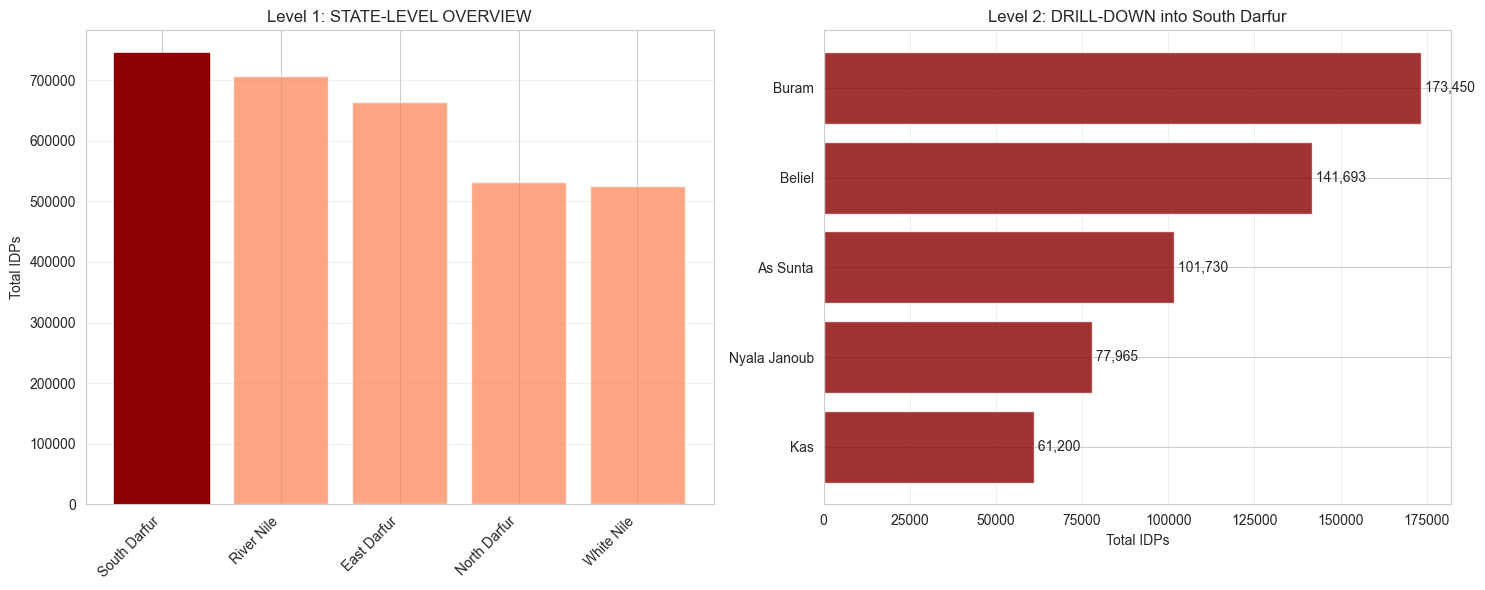

In [18]:
# Pick a high-IDP state for demonstration
example_state = idps_state.nlargest(1, "total_idps")["state_displacement"].iloc[0]

print(f"HIERARCHICAL VIEW EXAMPLE: {example_state}")

state_summary = idps_state[idps_state["state_displacement"] == example_state].iloc[0]
print("\nSTATE-LEVEL OVERVIEW (Initial Map View)")
print(f"   Total IDPs: {state_summary['total_idps']:,}")
print(f"   Households: {state_summary['total_households']:,}")
print(f"   % of National IDPs: {state_summary['displacement_concentration_pct']:.1f}%")

# Locality-level detail (what user sees when drilling down)
localities_in_state = idps_locality[
    idps_locality["state_displacement"] == example_state
].nlargest(5, "total_idps")

print("\nLOCALITY-LEVEL DETAIL (Drill-Down View)")
print(f"   Top 5 Localities in {example_state}:")
print(f"   {'Locality':<25} {'IDPs':>12} {'% of State':>12}")
print(f"   {'-'*50}")

for _, loc in localities_in_state.iterrows():
    pct_of_state = (loc["total_idps"] / state_summary["total_idps"]) * 100
    print(
        f"   {loc['locality_displacement']:<25} {loc['total_idps']:>12,} {pct_of_state:>11.1f}%"
    )

print(
    f"\n   Total localities in {example_state}: {len(idps_locality[idps_locality['state_displacement'] == example_state])}"
)

# Visualization of drill-down concept
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# State level view (what you see first)
top_5_states = idps_state.nlargest(5, "total_idps")
ax1.bar(range(len(top_5_states)), top_5_states["total_idps"], color="coral", alpha=0.7)
ax1.set_xticks(range(len(top_5_states)))
ax1.set_xticklabels(top_5_states["state_displacement"], rotation=45, ha="right")
ax1.set_ylabel("Total IDPs")
ax1.set_title("Level 1: STATE-LEVEL OVERVIEW")
ax1.grid(axis="y", alpha=0.3)

# Highlight the example state
example_idx = (
    list(top_5_states["state_displacement"]).index(example_state)
    if example_state in list(top_5_states["state_displacement"])
    else None
)
if example_idx is not None:
    ax1.get_children()[example_idx].set_color("darkred")
    ax1.get_children()[example_idx].set_alpha(1.0)

# Locality level view (drill-down into example state)
ax2.barh(
    range(len(localities_in_state)),
    localities_in_state["total_idps"],
    color="darkred",
    alpha=0.8,
)
ax2.set_yticks(range(len(localities_in_state)))
ax2.set_yticklabels(localities_in_state["locality_displacement"])
ax2.set_xlabel("Total IDPs")
ax2.set_title(f"Level 2: DRILL-DOWN into {example_state}")
ax2.invert_yaxis()
ax2.grid(axis="x", alpha=0.3)

for i, v in enumerate(localities_in_state["total_idps"]):
    ax2.text(v, i, f" {v:,}", va="center")

plt.tight_layout()
plt.show()

In [19]:
print("\nDASHBOARD IMPLEMENTATION NOTE:")
print("   This hierarchical structure enables:")
print("   1. Fast overview at state level (fewer polygons to render)")
print("   2. Detailed analysis when user clicks/zooms into a state")
print("   3. Clear navigation: 'zoom in' to locality, 'zoom out' to state")


DASHBOARD IMPLEMENTATION NOTE:
   This hierarchical structure enables:
   1. Fast overview at state level (fewer polygons to render)
   2. Detailed analysis when user clicks/zooms into a state
   3. Clear navigation: 'zoom in' to locality, 'zoom out' to state


## 6. Data Quality and Completeness Assessment
### 6.1 IDP Data Completeness

In [20]:
completeness_checks = {
    "Localities with origin breakdown": idps_locality["has_origin_breakdown"].sum(),
    "Localities with complete nationality data": idps_locality[
        "nationality_data_complete"
    ].sum(),
    "States with displacement data": len(idps_state),
    "Total locality records": len(idps_locality),
}

print("IDP DATA COMPLETENESS:")
for check, value in completeness_checks.items():
    if "Total" in check:
        print(f"{check}: {value}")
    else:
        pct = value / len(idps_locality) * 100
        print(f"{check}: {value} ({pct:.1f}%)")

IDP DATA COMPLETENESS:
Localities with origin breakdown: 181 (100.0%)
Localities with complete nationality data: 181 (100.0%)
States with displacement data: 18 (9.9%)
Total locality records: 181


### 5.2 Geographic Coverage

In [21]:
# States represented in data
print("\nGEOGRAPHIC COVERAGE:")
print(f"Total states in Sudan: {len(states)}")
print(f"States with IDP data: {len(idps_state)}")
print(f"Total localities: {len(localities)}")
print(f"Localities with IDP data: {len(idps_locality)}")
print(f"\nCoverage: {len(idps_locality)/len(localities)*100:.1f}% of localities")


GEOGRAPHIC COVERAGE:
Total states in Sudan: 19
States with IDP data: 18
Total localities: 189
Localities with IDP data: 181

Coverage: 95.8% of localities


## 6. Summary and Next Steps

### Key Findings from Exploration

**IDP Distribution:**
- Total of ~6.55 million IDPs across Sudan
- Highly concentrated: top 3 states (River Nile, South Darfur, East Darfur) host ~30% of all IDPs
- Khartoum is the primary origin of displacement, indicating conflict intensity
- Average household size is ~5 people

**Health Facilities:**
- 1,126 total facilities identified
- Only 238 critical facilities (hospitals + clinics) - 21% of total
- 97% have original names, 86% have English translations
- High data quality with valid coordinates for nearly all facilities

**Geographic Distribution:**
- Darfur region (multiple states) shows both high IDP numbers and conflict origins
- River Nile state hosts the most IDPs despite not being a primary conflict zone
- Potential mismatches between IDP concentrations and facility locations need formal spatial analysis

**Data Quality:**
- IDP data is complete and well-structured at state and locality levels
- Health facility data has high precision and completeness
- Origin state data provides clear picture of displacement patterns
- Nationality breakdown shows predominantly Sudanese IDPs
 
### Questions for Analysis Phase

1. **Spatial Accessibility:** What is the actual distance between IDP concentrations and the nearest hospital or clinic?
2. **Service Gaps:** Which localities have the worst IDP-to-facility ratios when accounting for geographic distance?
3. **Capacity Analysis:** Are facilities in high-IDP areas actually operational and adequately staffed?
4. **Vulnerability Mapping:** Can we create a composite vulnerability score based on:
- IDP population density
- Distance to nearest critical facility
- Displacement concentration
- Household size

### Next Steps

The analysis phase (Milestone 3) will:
- Conduct geospatial proximity analysis using coordinates
- Calculate accessibility metrics (travel time, distance)
- Create "Map of Vulnerability" showing critical gaps
- Generate locality-level vulnerability rankings
- Prepare recommendations for resource allocation

**Note:** This exploration has revealed the data is suitable for the planned 
geospatial analysis. No major data quality issues identified.
